In [19]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("./Utils")
from utils import get_padded_loaders, load_checkpoint
from monai.networks.nets import UNETR

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

kwargs = {'train_dir': '../Data/dataset_DRIVE/training/images',
          'train_maskdir': '../Data/dataset_DRIVE/training/1st_manual',
          'val_dir': '../Data/dataset_DRIVE/validation/images',
          'val_maskdir': '../Data/dataset_DRIVE/validation/1st_manual',
          'batch_size': 3,
          'rotation': [-45, 45],
          'hflip_prob': 0.3,
          'brightness': [0.5, 1.5],
          'contrast': [0.5, 1.5],
          'gamma': [0.7, 1.3],
          'affine_prob': 0.4,
          'affine_translate': [0.05, 0.1],  # Horiz and vert translation
          'affine_scale': [1, 1.3],
          'affine_shears': [0, 0],
          'noise': (0, 0.2),  # (Mean,std)
          'num_workers': 0,
          'pin_memory': True}

In [20]:
train_loader, val_loader = get_padded_loaders(**kwargs)

Feature batch shape: torch.Size([3, 3, 576, 576])
Labels batch shape: torch.Size([3, 576, 576])
The Train image numbers present in the batch are: ('22', '33', '23')


Text(0.5, 1.0, '22')

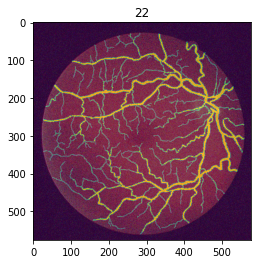

In [21]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

# Model 

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
day_and_run = "2022_04_03_1"
logs = f"./Checkpoints_UNETR/{day_and_run}/training_logs.pt"
weights = f"./Checkpoints_UNETR/{day_and_run}/my_check.pth.tar"

In [23]:
logs = torch.load(logs)

In [24]:
print(logs["best_auc"])
print(logs["best_accuracy"])
print(logs["best_dice"])

0.9504296671001238
0.9637217580536266
0.7893005705718847


# Submission Grand Challenge

In [38]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test/images"

In [82]:
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
from PIL import Image, ImageOps
from torch.utils.data import Dataset
import torchvision

In [116]:
class DRIVE_dataset_padding (Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def transform_test(self, image):
        # Padding
        image = TF.pad(image, (5, 0, 6, 0), padding_mode="constant", fill=0) #left, top, right and bottom
        # Cropping
        image = ImageOps.crop(image, (0, 4, 0, 4))
        # Transform to tensor
        tens = ToTensor()
        image = tens(image)
        return image

    def __getitem__(self, index):

        number = self.images[index][0:2]
        image = f'{number}_test.tif'

        img_path = os.path.join(self.image_dir, image)

        img = Image.open(img_path).convert("RGB")

        # Fuerzo a 3 canales aunque solo sea uno para poder
        # aplicarle las mismas transformaciones
        img = self.transform_test(img)

        # Devuelvo solo 1 canal del label
        return img, number

def get_padded_loaders(
    test_dir,
    batch_size,
    num_workers,
    pin_memory
):

    test_ds = DRIVE_dataset_padding(
        image_dir=test_dir
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return test_loader

In [117]:
# Model Hyperparams
BATCH_SIZE = 1
FEATURE_SIZE = 64
DROPOUT_RATE = 0
test_loader = get_padded_loaders(TEST_IMG_DIR, 1, 0, True)

In [118]:
model = UNETR(in_channels=3, out_channels=1, img_size=576, spatial_dims=2, feature_size=FEATURE_SIZE, dropout_rate=DROPOUT_RATE).to(DEVICE)
load_checkpoint(torch.load(weights, map_location=torch.device(DEVICE)),
    model)
model.eval()
if not os.path.exists(f"../Data/dataset_DRIVE/submit_UNETR/{day_and_run}"):
    os.makedirs(f"../Data/dataset_DRIVE/submit_UNETR/{day_and_run}")
for i in test_loader:
    image = i[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(image))
        preds = (preds > 0.5).float()
        preds = TF.pad(preds, (0, 4, 0, 4), padding_mode="constant", fill=0)
        preds = preds[:, :, :, 5:570]
        torchvision.utils.save_image(
                preds, f"../Data/dataset_DRIVE/submit_UNETR/{day_and_run}/{i[1][0]}"+".png")


 => Loading checkpoint 


In [119]:
problematic = next(iter(test_loader))[0][2]

In [120]:
problematic = problematic.unsqueeze(0)
x = problematic.to(device=DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()

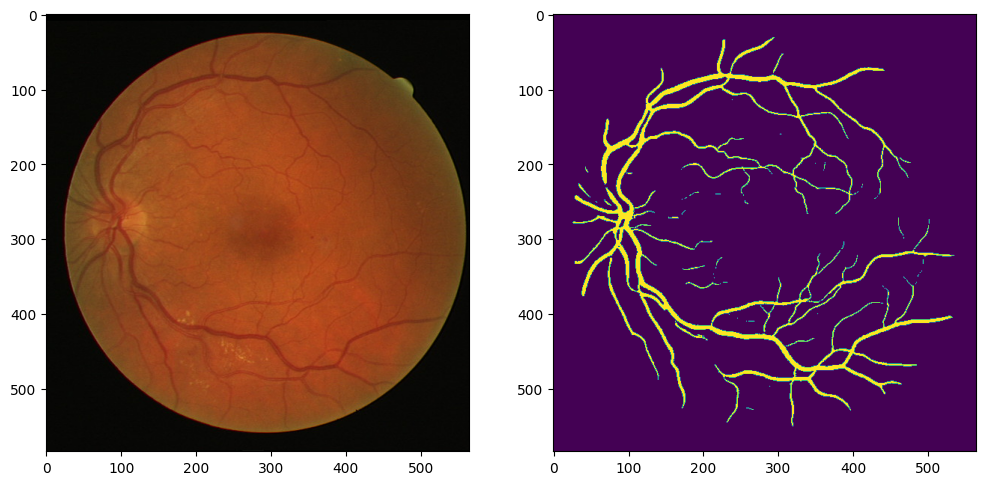

In [121]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots(1,2)
ax[0].imshow(problematic.squeeze(0).permute(1, 2, 0))
ax[1].imshow(preds.squeeze(0).squeeze(0))